In [1]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
import PIL
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from io import BytesIO
import svgwrite

In [7]:
icon_name = "hardboardIcon"

(385, 119, 4)


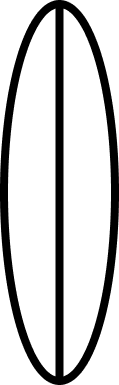

In [8]:

image = PIL.Image.open(f'icons/{icon_name}.png')
data = np.asarray(image)
print(data.shape)
image


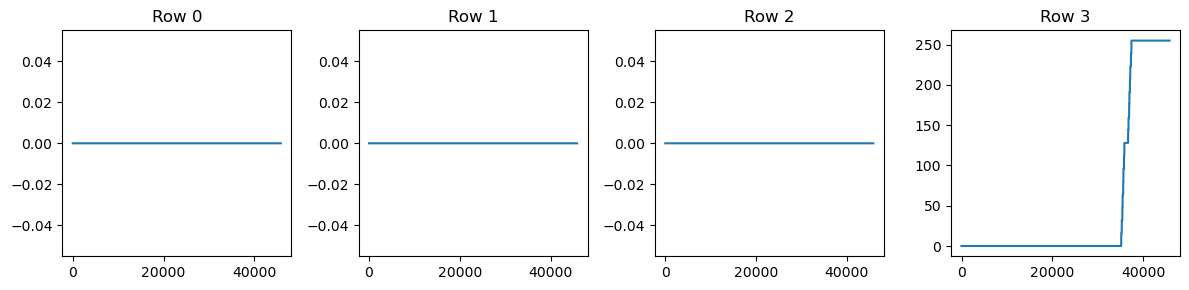

In [9]:
flat_arr = data.reshape((data.shape[0]*data.shape[1], 4))
arr = flat_arr.T

# create a 2x2 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

# loop through the rows of arr and plot each row in a subplot
for i, row in enumerate(arr):
    ordered = np.sort(row)
    ax = axs[i]  # select the correct subplot for this row
    ax.plot(ordered)
    ax.set_title(f"Row {i}")  # set the title of the subplot to the row number

# adjust the layout of the subplots and show the figure
fig.tight_layout()
plt.show()



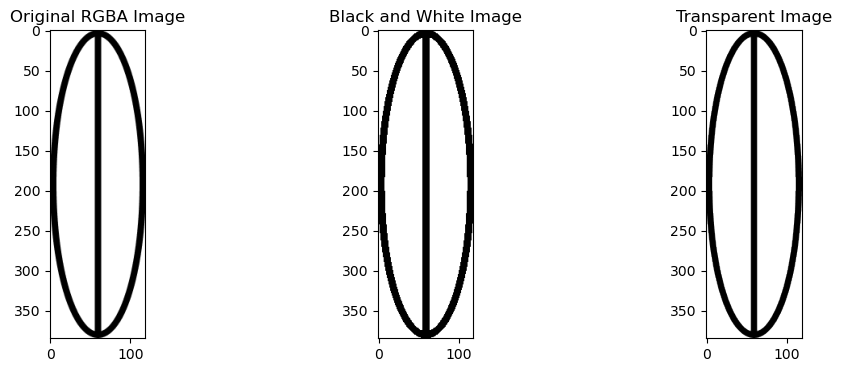

In [10]:
# extract the RGB components
rgb_data = data[:, :, :3]
a_data = np.expand_dims(data[:, :, -1],-1)

# create a boolean mask for pixels with conditions
# low_rgb_mask = (rgb_data < 225).all(axis=-1) & (rgb_data > 50).all(axis=-1)
low_rgb_mask = (rgb_data < 50).all(axis=-1) & (a_data > 0.5).all(axis=-1)

# create a new array for the black and white image
bw_data = np.zeros((data.shape[0], data.shape[1]), dtype=np.uint8)

# set pixels with low RGB values to black and all others to white
bw_data[low_rgb_mask] = 0
bw_data[~low_rgb_mask] = 255

# create a new RGBA image from the black and white image, preserving the original alpha channel
rgba_bw_data = np.zeros((bw_data.shape[0], bw_data.shape[1], 4), dtype=np.uint8)
rgba_bw_data[:, :, 0] = bw_data
rgba_bw_data[:, :, 1] = bw_data
rgba_bw_data[:, :, 2] = bw_data
rgba_bw_data[:, :, 3] = data[:, :, 3]

# set the alpha channel to zero for all white pixels
white_pixels = (rgba_bw_data[:, :, :3] == 255).all(axis=-1)
rgba_bw_data[white_pixels, 3] = 0

# plot the original RGBA image, the black and white image, and the transparent image side by side
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
axs[0].imshow(data)
axs[0].set_title("Original RGBA Image")
axs[1].imshow(bw_data, cmap="gray")
axs[1].set_title("Black and White Image")
axs[2].imshow(rgba_bw_data)
axs[2].set_title("Transparent Image")
plt.show()


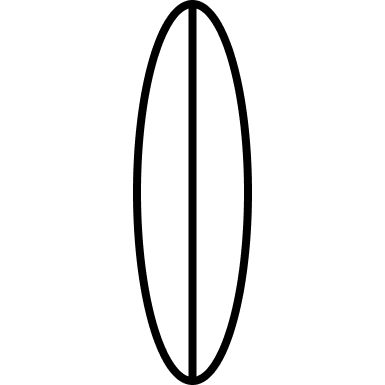

In [11]:


# Make the image square
width, height = rgba_bw_data.shape[:2]
size = max(width, height)
square_rgba_bw_data = np.zeros((size, size, 4), dtype=np.uint8)
square_rgba_bw_data[:, :, 3] = 0  # Set alpha channel to 0 (transparent) for all pixels
left_border_width = int((size-height)/2)
right_border_width = (size - height) - left_border_width 
square_rgba_bw_data[:width, left_border_width:size-right_border_width] = rgba_bw_data

# Function to convert RGBA image to SVG using svgwrite
def rgba_image_to_svg(rgba_data):
    width, height, _ = rgba_data.shape
    dwg = svgwrite.Drawing(size=(width, height), profile='tiny', debug=True)
    
    for y in range(height):
        for x in range(width):
            r, g, b, a = rgba_data[y, x]
            if a != 0:
                color = f"rgb({r},{g},{b})"
                opacity = a / 255
                dwg.add(dwg.rect(insert=(x, y), size=(1, 1), fill=color, opacity=opacity))

    return dwg.tostring()

# Convert the square RGBA image to an SVG
svg_data = rgba_image_to_svg(square_rgba_bw_data)

# Display the SVG
from IPython.display import SVG, display
display(SVG(svg_data))

# Save the SVG to the icons/ folder
with open(f"icons/{icon_name}.svg", "w") as svg_file:
    svg_file.write(svg_data)
